In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sb
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.feature_selection import SelectFromModel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score

In [2]:
train_data = pd.read_csv('train.csv').sample(frac=0.3)
pred_data = pd.read_csv('promotion_schedule.csv')

## Clean & Split Data

In [3]:
# dummy the categories
train_data = pd.get_dummies(train_data, columns=['j', 'i'])

In [4]:
# split into X and y
foo = train_data.copy()
y = foo.pop('price')
X = foo
del foo

In [5]:
def time_split(X, y, test_start_time):
    '''
    Splits data based on a sinlge point in time
    '''
    train_index = X.t < test_start_time
    test_index = X.t >= test_start_time
    X_train, y_train = X[ train_index], y[ train_index]
    X_test, y_test = X[ test_index ], y[ test_index ]
    print('Data used to test: {} %'.format(round(len(y_test) / ( len(y_test) + len(y_train) ), 3) * 100))
    return X_train, X_test, y_train, y_test

In [6]:
# split data
split_by_time = True
if split_by_time:
    X_train, X_test, y_train, y_test = time_split(X, y, 39)
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Data used to test: 20.3 %


## Model

In [7]:
def test_acc(model, X_train, X_test, y_train, y_test):
    '''
    Determine negative mean absolute error for test data
    '''
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    return -abs(np.array(pred) - np.array(y_test)).mean()

In [8]:
def class_crossval_plot(X_train, X_test, y_train, y_test, models, splits=6, scoring='neg_mean_absolute_error'):
    """
    Create violin plot of multiple models' test scores
    Inputs:
        X - dataframe features
        y - dataframe target column
        models - list of sklearn models to test
        scoring - measure of best fit for models to use
    """
    results = []
    names = []
    all_scores = []
    print('Mod - Avg - Std Dev')
    print('---   ---   -------')
    for model in models:
        name = model.__class__.__name__
        kfold = KFold(n_splits=splits)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=-1)
        results.append(cv_results)
        names.append(name)
        print('{}: {:.4f} ({:4f})'.format(name, cv_results.mean(), cv_results.std()))
        print('Test acc: {:.4f}'.format(test_acc(model, X_train, X_test, y_train, y_test)))
        print()

    fig = plt.figure(figsize=(16, 10))
    plt.tight_layout()
    fig.suptitle('Cross Validation Comparison of Regression Models')
    ax = fig.add_subplot(111)
    sb.violinplot(data=results, orient='v')
    ax.set_xticklabels(names, rotation=50, ha='right')
    ax.set_xlabel('Model')
    plt.grid(alpha=0.4)

Mod - Avg - Std Dev
---   ---   -------
Ridge: -0.0307 (0.000616)
Test acc: -0.0313

KNeighborsRegressor: -0.0346 (0.002015)
Test acc: -0.1378

DecisionTreeRegressor: -0.0004 (0.000229)
Test acc: -0.0100

RandomForestRegressor: -0.0005 (0.000224)
Test acc: -0.0099

ExtraTreesRegressor: -0.0002 (0.000117)
Test acc: -0.0083

GradientBoostingRegressor: -0.1461 (0.001860)
Test acc: -0.1512

MLPRegressor: -0.0194 (0.000869)
Test acc: -0.0236



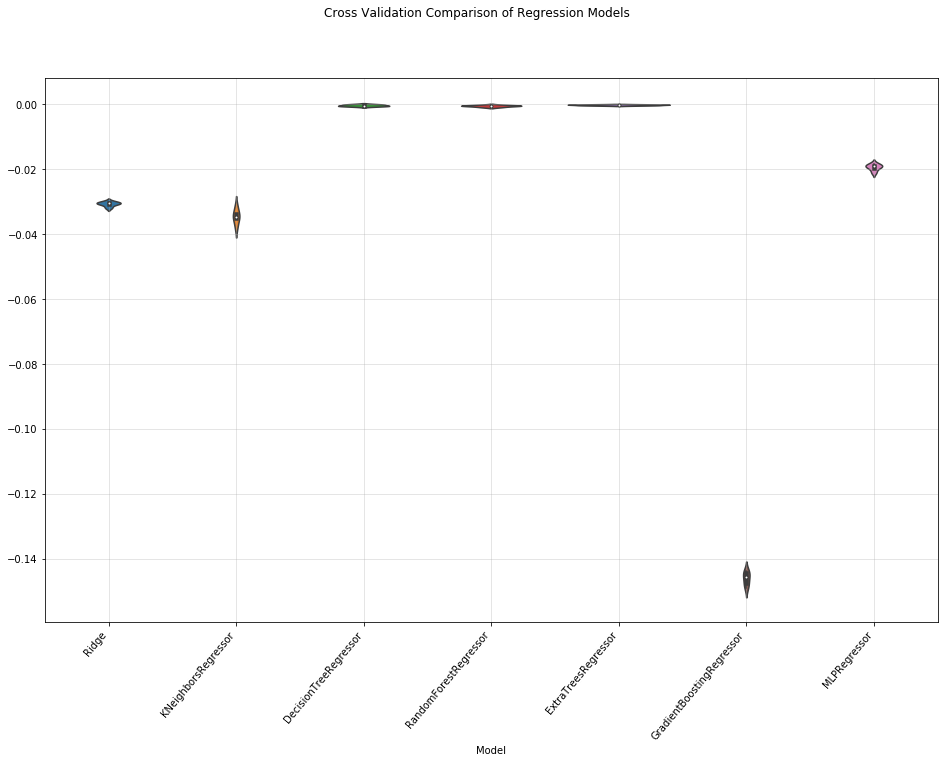

In [15]:
# Initial Cross Validation
models = []
models.append(Ridge())
models.append(KNeighborsRegressor(n_jobs=-1))
models.append(DecisionTreeRegressor())
models.append(RandomForestRegressor())
models.append(ExtraTreesRegressor())
models.append(GradientBoostingRegressor())
models.append(MLPRegressor())

class_crossval_plot(X_train, X_test, y_train, y_test, models)

In [9]:
def clust_grid(model, params, X_train, y_train):
    """
    Grid search over model
    Inputs:
        model - sklearn model to use (ie Lasso())
        params - parameter grid to search over for each model
        X_train - features to train model with
        y_train - targets to validate model with
    Returns:
        list of the best parameters found by the grid search
    """
    test_model = model
    grid = GridSearchCV(test_model, param_grid=params, n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)
    return grid.best_params_, grid.best_score_

In [ ]:
# grid search RF
rf = RandomForestRegressor()
params = {'n_estimators': [10, 30], 'max_features': ['auto', 0.3], 'min_samples_split': [2, 4], 'n_jobs': [-1]}
best_params, best_score = clust_grid(rf, params, X_train, y_train)
print(best_params)
print(best_score)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


In [30]:
# grid search ET
et = ExtraTreesRegressor()
params = {'n_estimators': [10, 30], 'max_features': ['auto', 0.3], 'n_jobs': [-1]}
best_params, best_score = clust_grid(et, params, X_train, y_train)
print(best_params)
print(best_score)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  2.0min finished


{'max_features': 'auto', 'n_estimators': 30, 'n_jobs': -1}
0.9998343971280224


## Final Model & Predictions

In [44]:
pred_data = pred_data.set_index('j')

In [48]:
train_data.head()

,i,j,t,price,advertised
18483,1655,39,11,1.281862,0
23020,1554,5,14,1.750835,0
39673,733,6,25,0.799155,0
2411,1005,14,1,3.149620,0
43070,1065,6,27,0.799155,0


In [52]:
week_50 = pd.DataFrame(columns=['i', 'j', 't', 'advertised'])
t = 50
for i in range(0, 2000):
    for index, row in pred_data.iterrows():
        

1999

In [ ]:
et_model = ExtraTreesRegressor(n_estimators=30, max_features='auto', n_jobs=-1)